<a href="https://colab.research.google.com/github/amandabetania/Domain-Frekuensi/blob/main/Tugas_Domain_Frekuensi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('/content/bunga.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

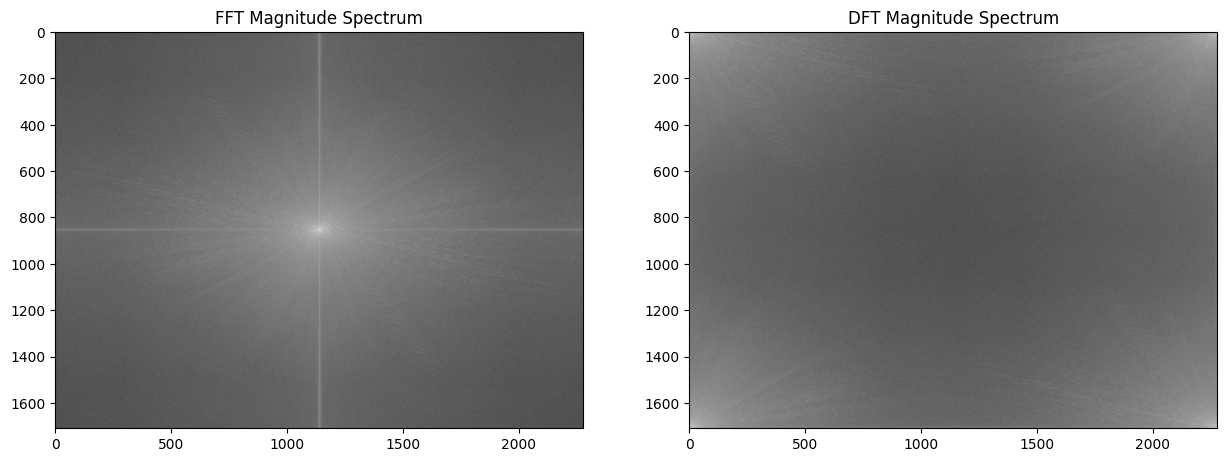

In [3]:
#FFT & DFT
def fft2(a):
    return np.fft.fft2(a)

def idft2(a):
    return np.fft.ifft2(a)

def dft2(a):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(a)))

def idft2(a):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(a)))

# FFT
f = fft2(gray)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
# DFT
d = dft2(gray)
dshift = np.fft.fftshift(d)
magnitude_spectrum_dft = 20*np.log(np.abs(dshift))

plt.figure(figsize=(15, 10))
plt.subplot (121), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('FFT Magnitude Spectrum')
plt.subplot(122), plt.imshow(magnitude_spectrum_dft, cmap='gray')
plt.title('DFT Magnitude Spectrum')
plt.show()

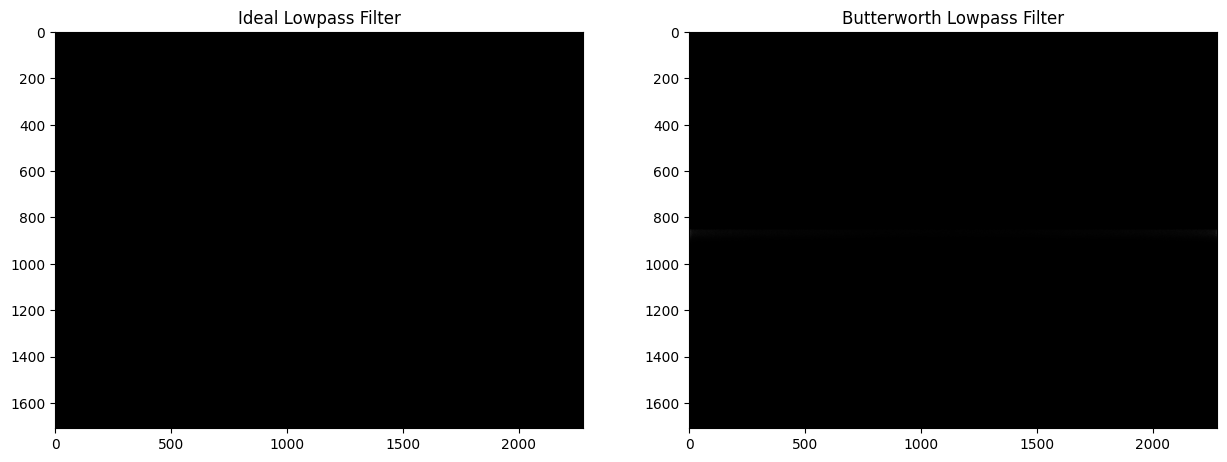

In [4]:
#Ideal Lowpass Filter & Butterworth Lowpass Filter
def ideal_lowpass_filter(shape, cutoff):
    h = np.zeros(shape)
    h[(shape[0]//2-cutoff):(shape[0]//2+cutoff), (shape[1]//2-cutoff):(shape[1]//2+cutoff)] = 1
    return h

def butterworth_lowpass_filter(shape, cutoff, order):
    r, theta = np.ogrid[:shape[0], :shape[1]]
    r = r/cutoff
    theta = theta*2*np.pi
    h = 1/(1 + (r**order)**2)
    return h

# Ideal Lowpass Filter
ilf = ideal_lowpass_filter(gray.shape, 30)
ilf_filtered = dft2(ilf*d)
ilf_filtered_img = np.fft.ifft2(np.fft.ifftshift(ilf_filtered))
ilf_filtered_img = np.abs(ilf_filtered_img)

# Butterworth Lowpass Filter
blf = butterworth_lowpass_filter(gray.shape, 30, 2)
blf_filtered = dft2(blf*d)
blf_filtered_img = np.fft.ifft2(np.fft.ifftshift(blf_filtered))
blf_filtered_img = np.abs(blf_filtered_img)

plt.figure(figsize=(15, 10))
plt.subplot(121), plt.imshow(ilf_filtered_img, cmap='gray')
plt.title('Ideal Lowpass Filter')
plt.subplot(122), plt.imshow(blf_filtered_img, cmap='gray')
plt.title('Butterworth Lowpass Filter')
plt.show()

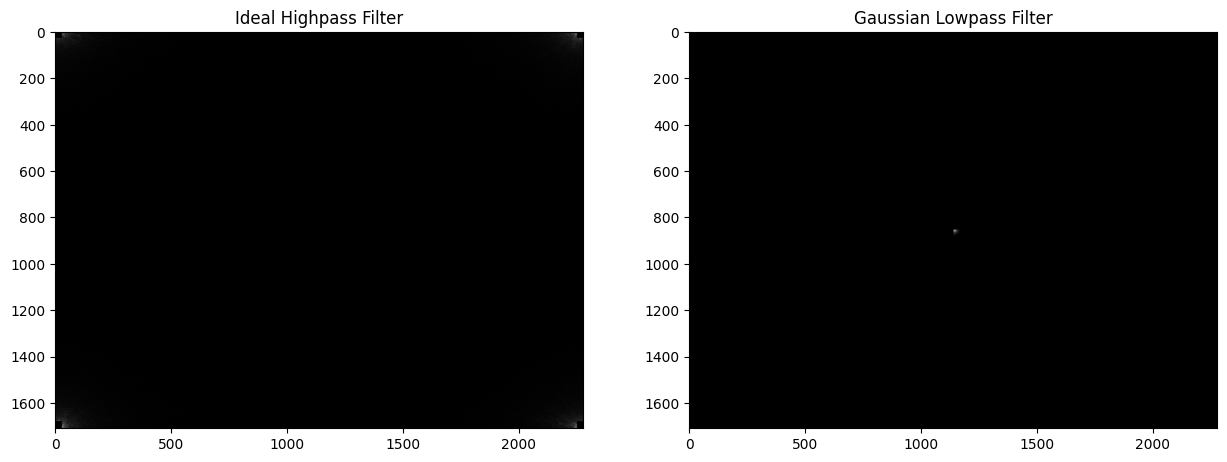

In [5]:
#Gaussian Lowpass Filter & Ideal Highpass Filter
def gaussian_lowpass_filter(shape, cutoff):
    r, theta = np.ogrid[:shape[0], :shape[1]]
    sigma = cutoff/3
    h = np.exp(-(r**2 + theta**2)/(2*sigma**2))
    return h

def ideal_highpass_filter(shape, cutoff):
    h = np.ones(shape)
    h[(shape[0]//2-cutoff):(shape[0]//2+cutoff), (shape[1]//2-cutoff):(shape[1]//2+cutoff)] = 0
    return h

# Gaussian Lowpass Filter
glf = gaussian_lowpass_filter(gray.shape, 30)
glf_filtered = dft2(glf*d)
glf_filtered_img = np.fft.ifft2(np.fft.ifftshift(glf_filtered))
glf_filtered_img = np.abs(glf_filtered_img)

# Ideal Highpass Filter
ihf = ideal_highpass_filter(gray.shape, 30)
ihf_filtered = dft2(ihf*d)
ihf_filtered_img = np.fft.ifft2(np.fft.ifftshift(ihf_filtered))
ihf_filtered_img = np.abs(ihf_filtered_img)

plt.figure(figsize=(15, 10))
plt.subplot(121), plt.imshow(ihf_filtered_img, cmap='gray')
plt.title('Ideal Highpass Filter')
plt.subplot(122), plt.imshow(glf_filtered_img, cmap='gray')
plt.title('Gaussian Lowpass Filter')
plt.show()

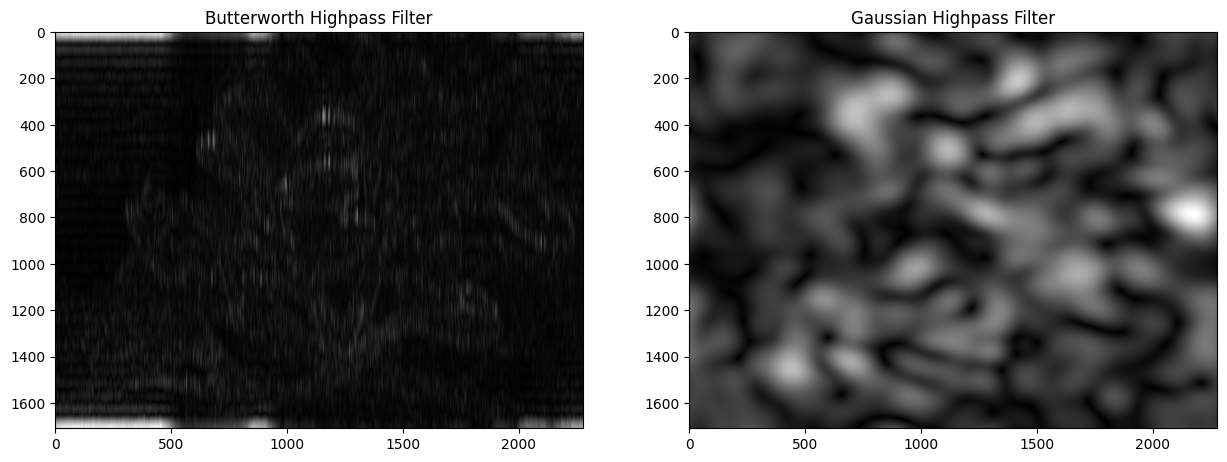

In [6]:
#Butterworth Highpass Filter
def butterworth_highpass_filter(image, cutoff, order):
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    r, theta = np.ogrid[:rows, :cols]
    r = r/cutoff
    theta = theta*2*np.pi
    h = 1 / (1 + (r**order)**2)
    h[r > 1] = 0
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fshift *= h
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

#Gaussian Highpass Filter
def gaussian_highpass_filter(image, cutoff, sigma):
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    r, theta = np.ogrid[:rows, :cols]
    sigma_squared = 2*sigma**2
    r_squared = r**2 + theta**2
    h = np.exp(-r_squared/(2*sigma_squared))
    mask = np.zeros((rows, cols), dtype=bool)
    mask[(r > cutoff) & (r < rows - cutoff) & (theta > cutoff) & (theta < cols - cutoff)] = True
    h[mask] = 0
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fshift *= h
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

# Butterworth Highpass Filter
bpf = butterworth_highpass_filter(gray, 30, 2)

# Gaussian Highpass Filter
ghf = gaussian_highpass_filter(gray, 30, 5)

plt.figure(figsize=(15, 10))
plt.subplot(121), plt.imshow(bpf, cmap='gray')
plt.title('Butterworth Highpass Filter')
plt.subplot(122), plt.imshow(ghf, cmap='gray')
plt.title('Gaussian Highpass Filter')
plt.show()

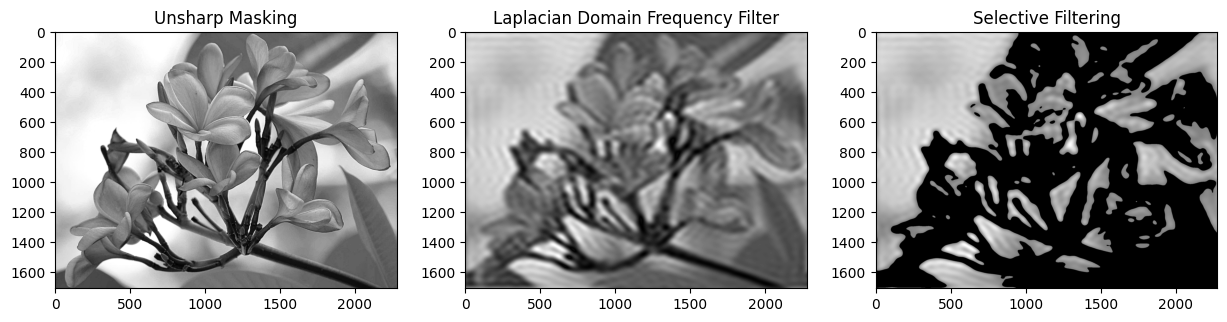

In [7]:
#Filter Unsharp Masking
def unsharp_masking(image, blur_ksize, sharpen_ksize, sharpen_amount):
    blurred = cv2.GaussianBlur(image, blur_ksize, 0)
    sharpened = cv2.addWeighted(image, 1 + sharpen_amount, blurred, -sharpen_amount, 0)
    return sharpened

#Filter Laplacian Domain Frekuensi
def laplacian_domain_frequency_filter(image, cutoff):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 1
    f = dft_shift*mask
    fshift = np.fft.ifftshift(f)
    img_back = cv2.idft(fshift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    return img_back

#Selective Filtering
def selective_filtering(image, cutoff):
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    rows, cols = image.shape
    crow, ccol = rows//2, cols//2
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-cutoff:crow+cutoff, ccol-cutoff:ccol+cutoff] = 1
    f = dft_shift*mask
    fshift = np.fft.ifftshift(f)
    img_back = cv2.idft(fshift)
    img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
    img_back[img_back < np.mean(img_back)] = 0
    return img_back

# Unsharp Masking
usm = unsharp_masking(gray, (5, 5), (3, 3), 1.5)
# Laplacian Domain Frequency Filter
ldff = laplacian_domain_frequency_filter(gray, 30)
# Selective Filtering
sf = selective_filtering(gray, 30)

plt.figure(figsize=(15, 10))
plt.subplot(131), plt.imshow(usm, cmap='gray')
plt.title('Unsharp Masking')
plt.subplot(132), plt.imshow(ldff, cmap='gray')
plt.title('Laplacian Domain Frequency Filter')
plt.subplot(133), plt.imshow(sf, cmap='gray')
plt.title('Selective Filtering')
plt.show()